In [83]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [84]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")
#vueltas.drop(['Piloto'], axis = 1, inplace = True)
vueltas.drop(['nextPit'], axis = 1, inplace = True)
vueltas.drop(['makeStop'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020])]
vueltas_validation = vueltas[vueltas['anyo'].isin([2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

vueltas_test = vueltas_test[vueltas_test['Piloto'] == "hamilton"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_validation = vueltas_validation.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
#vueltas_test = vueltas_test.drop(['Stint'], axis=1)
vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
vueltas_validation.drop(['Piloto'], axis = 1, inplace = True)
vueltas_test.drop(['Piloto'], axis = 1, inplace = True)



vueltas_train = vueltas_train.astype(float)
vueltas_validation = vueltas_validation.astype(float)
vueltas_test = vueltas_test.astype(float)

In [85]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)
vueltas_validation_scaler = scaler.transform(vueltas_validation)

In [86]:
trainX = []
trainY = []
testX = []
testY = []
validationX = []
validationY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])
    
for i in range (loopback, len(vueltas_validation_scaler) -future +1):
    validationX.append(vueltas_validation_scaler[i-loopback:i, 0:vueltas_validation.shape[1]])
    validationY.append(vueltas_validation_scaler[i + future - 1:i + future,5])


In [87]:
trainX, trainY, testX, testY, validationX, validationY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY), np.array(validationX), np.array(validationY)

In [88]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 256)           281600    
                                                                 
 dropout_10 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 478,849
Trainable params: 478,849
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
48/48 [==============================] - 4s 42ms/step - loss: 0.0337
Epoch 2/12
48/48 [==============================] - 2s 39ms/step - loss: 0.0162
Epoch 3/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0138
Epoch 4/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0115
Epoch 5/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0110
Epoch 6/12
48/48 [==============================] - 2s 48ms/step - loss: 0.0103
Epoch 7/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0099
Epoch 8/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0093
Epoch 9/12
48/48 [==============================] - 2s 43ms/step - loss: 0.0086
Epoch 10/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0090
Epoch 11/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0085
Epoch 12/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0077


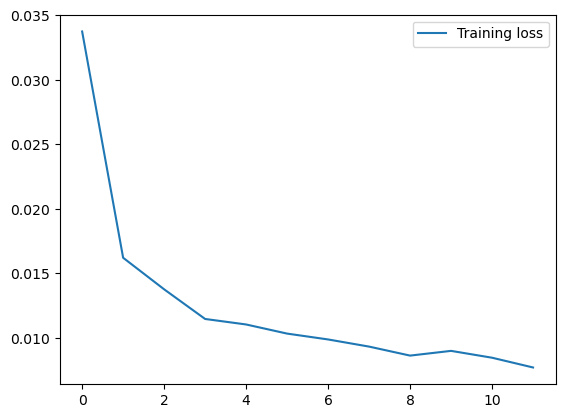

In [89]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [105]:
clases = np.unique(trainY[:,0]) #Cuidado de donde sacamos las clases, deberiamos sacarlas de train, 
#pero si en 2021 hubo una parada mas por lo que sea, falla lo de abajo, lo he hecho con validationY pero
# y si hace una menos en validation?
clases

#Por ejemplo en arabia saudi solo hubo 3 paradas, por lo cual es 0, 0,5 y 1. Si en validation hay 5,
#ya no coinciden, es decir, no las va a predecir, que es lo que hablamos la semana anterior


array([0.        , 0.33333333, 0.66666667, 1.        ])

In [106]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(validationY[:,0])

In [107]:
#AQUI ES CON LOS DATOS DE VALIDADACION
predictions = model.predict(validationX)

32/32 [==============================] - 0s 10ms/step


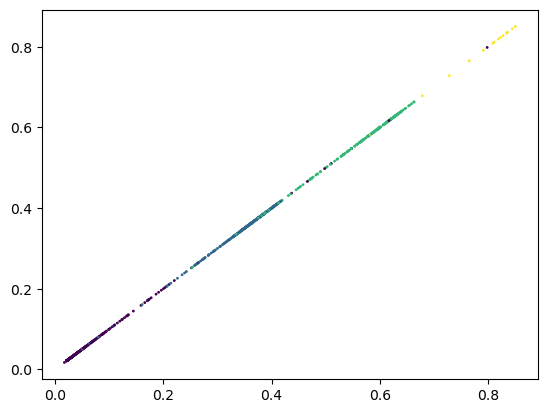

In [96]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [97]:
y_real_train = f(trainY[:,0])

In [98]:
predictions_test = model.predict(testX)

2/2 [==============================] - 0s 13ms/step


In [99]:
y_real_test =  f(testY[:,0])

In [100]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [101]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, y_real) # Esto es de validacion

In [102]:
pred_test_2 = rl.predict(predictions_test)

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_real_test, pred_test_2)
metricas = classification_report(y_real_test, pred_test_2)

/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/anaconda3/lib/pytho

In [104]:
print(cm)
print(metricas)

[[ 0  0  0  0]
 [11  0  0  0]
 [ 2 24  0  0]
 [ 0  1 16  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      11.0
           2       0.00      0.00      0.00      26.0
           3       0.00      0.00      0.00      17.0

    accuracy                           0.00      54.0
   macro avg       0.00      0.00      0.00      54.0
weighted avg       0.00      0.00      0.00      54.0

